#### pip install seaborn

In [557]:
# All imports
import pandas as pd
import glob
import os
import networkx as nx
import pickle
import numpy as np
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [558]:
# read data from CSV files
edgesFile = 'Raw/edges.csv'
nodesFile = 'Raw/nodes.csv'

edgesDf = pd.read_csv(edgesFile, sep=',')
edgesDf = edgesDf[["source", "sink"]]
print('edgesDf shape', edgesDf.shape)

nodesDf = pd.read_csv(nodesFile, sep=',')
print('nodesDf shape', nodesDf.shape)

edgesDf shape (559147, 2)
nodesDf shape (7751, 18)


In [559]:
# convert pval to float and use NaN for non numeric values
nodesDf['pval'] = pd.to_numeric(nodesDf['pval'], errors='coerce')

# remove nodes with empty or non-numeric pval
# nodesPvalDf = nodesDf[nodesDf['pval'].notna()]
# print('nodesPvalDf shape', nodesPvalDf.shape)

# construct dataframe with the selected features
tmp = nodesDf[['id', 'chromosome', 'jaccard_similarity', 'pval']]
tmp = tmp[tmp['chromosome'].notna()]
all_data = tmp[tmp['jaccard_similarity'].notna()]
print('all_data shape', all_data.shape)

all_data shape (5253, 4)


In [560]:
print(all_data.chromosome.value_counts())

14                                                                            442
1                                                                             441
19                                                                            375
11                                                                            298
2                                                                             296
21                                                                            293
7                                                                             290
3                                                                             260
10                                                                            257
17                                                                            243
5                                                                             236
6                                                                             220
12              

In [561]:
print('All data shape', all_data.shape)

# seperate data according to non-empty and empty pval
data_pval = all_data[all_data['pval'].notna()]
print('non-empty pval:', data_pval.shape)

data_emptyPval = all_data[all_data['pval'].isnull()]
print('empty pval:', data_emptyPval.shape)

All data shape (5253, 4)
non-empty pval: (1214, 4)
empty pval: (4039, 4)


In [562]:
# pval analysis
# max 1e-5, min 0, second min 1e-300
y = data_pval['pval']
print('second min:', y.nsmallest(2).iloc[-1])
print(y.describe())
print('small than 1e-10:', y[(y > 0) & (y < 1e-10)].count(), 'probable outliers counts.')

second min: 1e-300
count    1.214000e+03
mean     1.105047e-06
std      2.222589e-06
min      0.000000e+00
25%      5.000000e-10
50%      4.000000e-08
75%      8.000000e-07
max      1.000000e-05
Name: pval, dtype: float64
small than 1e-10: 257 probable outliers counts.


In [563]:
# remove the outliers
data_pval = data_pval[data_pval['pval'] >= 1e-10]
print(data_pval.shape)

(956, 4)


In [564]:
print('data with pval present = ')
print(data_pval.chromosome.value_counts())
print('-------------------------------------------------------------------------------------------------------------')
print()
print('data with pval absent =')
print(data_emptyPval.chromosome.value_counts())

# Understanding: model may not predict well on unknown chromosom named rows in testing set (data_emptyPval)

data with pval present = 
19                                                                            103
2                                                                              65
7                                                                              62
1                                                                              60
GCST9013226                                                                    48
3                                                                              46
11                                                                             45
5                                                                              42
GCST00592                                                                      40
8                                                                              39
15                                                                             39
6                                                                       

In [565]:
# All information before filtering
jacc_beforeFiltering = nodesDf[['jaccard_similarity']].dropna()
print("jacc_beforeFiltering shape = ", jacc_beforeFiltering.shape)
jacc_largest = jacc_beforeFiltering.nlargest(1, ['jaccard_similarity'])
print("jacc_largest = ", jacc_largest)
jacc_smallest = jacc_beforeFiltering.nsmallest(1, ['jaccard_similarity'])
print("jacc_smallest = ", jacc_smallest)
count = (jacc_beforeFiltering['jaccard_similarity'] == 0).sum()
print("# zeros before filtering = ", count)

print()
# All information after filtering
jacc_afterFiltering = nodesSelectedCols[nodesSelectedCols['jaccard_similarity'].notna()]
print("jacc_afterFiltering shape = ", jacc_afterFiltering.shape)
jacc_after_largest = jacc_afterFiltering.nlargest(1, ['jaccard_similarity'])
print("jacc_after_largest = ", jacc_after_largest)
jacc_after_smallest = jacc_afterFiltering.nsmallest(1, ['jaccard_similarity'])
print("jacc_after_smallest = ", jacc_after_smallest)
count = (jacc_afterFiltering['jaccard_similarity'] == 0).sum()
print("# zeros after filtering = ", count)


jacc_beforeFiltering shape =  (6015, 1)
jacc_largest =        jaccard_similarity
4342            0.096167
jacc_smallest =      jaccard_similarity
39                 0.0
# zeros before filtering =  133

jacc_afterFiltering shape =  (956, 4)
jacc_after_largest =        id chromosome          pval  jaccard_similarity
362  362         20  4.000000e-10            0.054468
jacc_after_smallest =        id   chromosome          pval  jaccard_similarity
877  877  GCST9013226  4.000000e-08                 0.0
# zeros after filtering =  23


In [566]:
data_pval

,id,chromosome,jaccard_similarity,pval
4,4,16,0.002947,4.000000e-08
7,7,15,0.012022,1.000000e-09
66,66,1,0.002709,9.000000e-06
71,71,7,0.002951,4.000000e-06
82,82,GCST00782,0.000247,6.000000e-10
...,...,...,...,...
7711,7711,7,0.004177,2.000000e-09
7712,7712,GCST00732,0.006143,1.000000e-08
7713,7713,18,0.002464,3.000000e-08
7714,7714,19,0.001723,5.000000e-08


In [567]:
# count number of rows by chromosome
# TODO clean up invalid chromosome

data_pval.loc[data_pval['chromosome'] == 'X', 'chromosome'] = '23'
data_pval.loc[data_pval['chromosome'] == 'Y', 'chromosome'] = '24'

# convert pval to float and use NaN for non numeric values
data_pval['chromosome'] = pd.to_numeric(data_pval['chromosome'], errors='coerce')
# remove nodes with empty or non-numeric pval
data_pval = data_pval[data_pval['chromosome'].notna()]

temp = data_pval.groupby('chromosome')['id'].nunique()
print(temp)

chromosome
1.0      60
2.0      65
3.0      46
4.0      24
5.0      42
6.0      38
7.0      62
8.0      39
9.0      14
10.0     28
11.0     45
12.0     38
13.0     13
14.0     22
15.0     39
16.0     21
17.0     28
18.0      9
19.0    103
20.0     12
21.0     10
22.0      7
23.0      1
Name: id, dtype: int64


In [568]:
# Chromosome groups (highest to lowest)

print(data_pval.chromosome.value_counts())
print('------------------------------------')
print(data_pval.shape)

19.0    103
2.0      65
7.0      62
1.0      60
3.0      46
11.0     45
5.0      42
8.0      39
15.0     39
12.0     38
6.0      38
10.0     28
17.0     28
4.0      24
14.0     22
16.0     21
9.0      14
13.0     13
20.0     12
21.0     10
18.0      9
22.0      7
23.0      1
Name: chromosome, dtype: int64
------------------------------------
(766, 4)


766


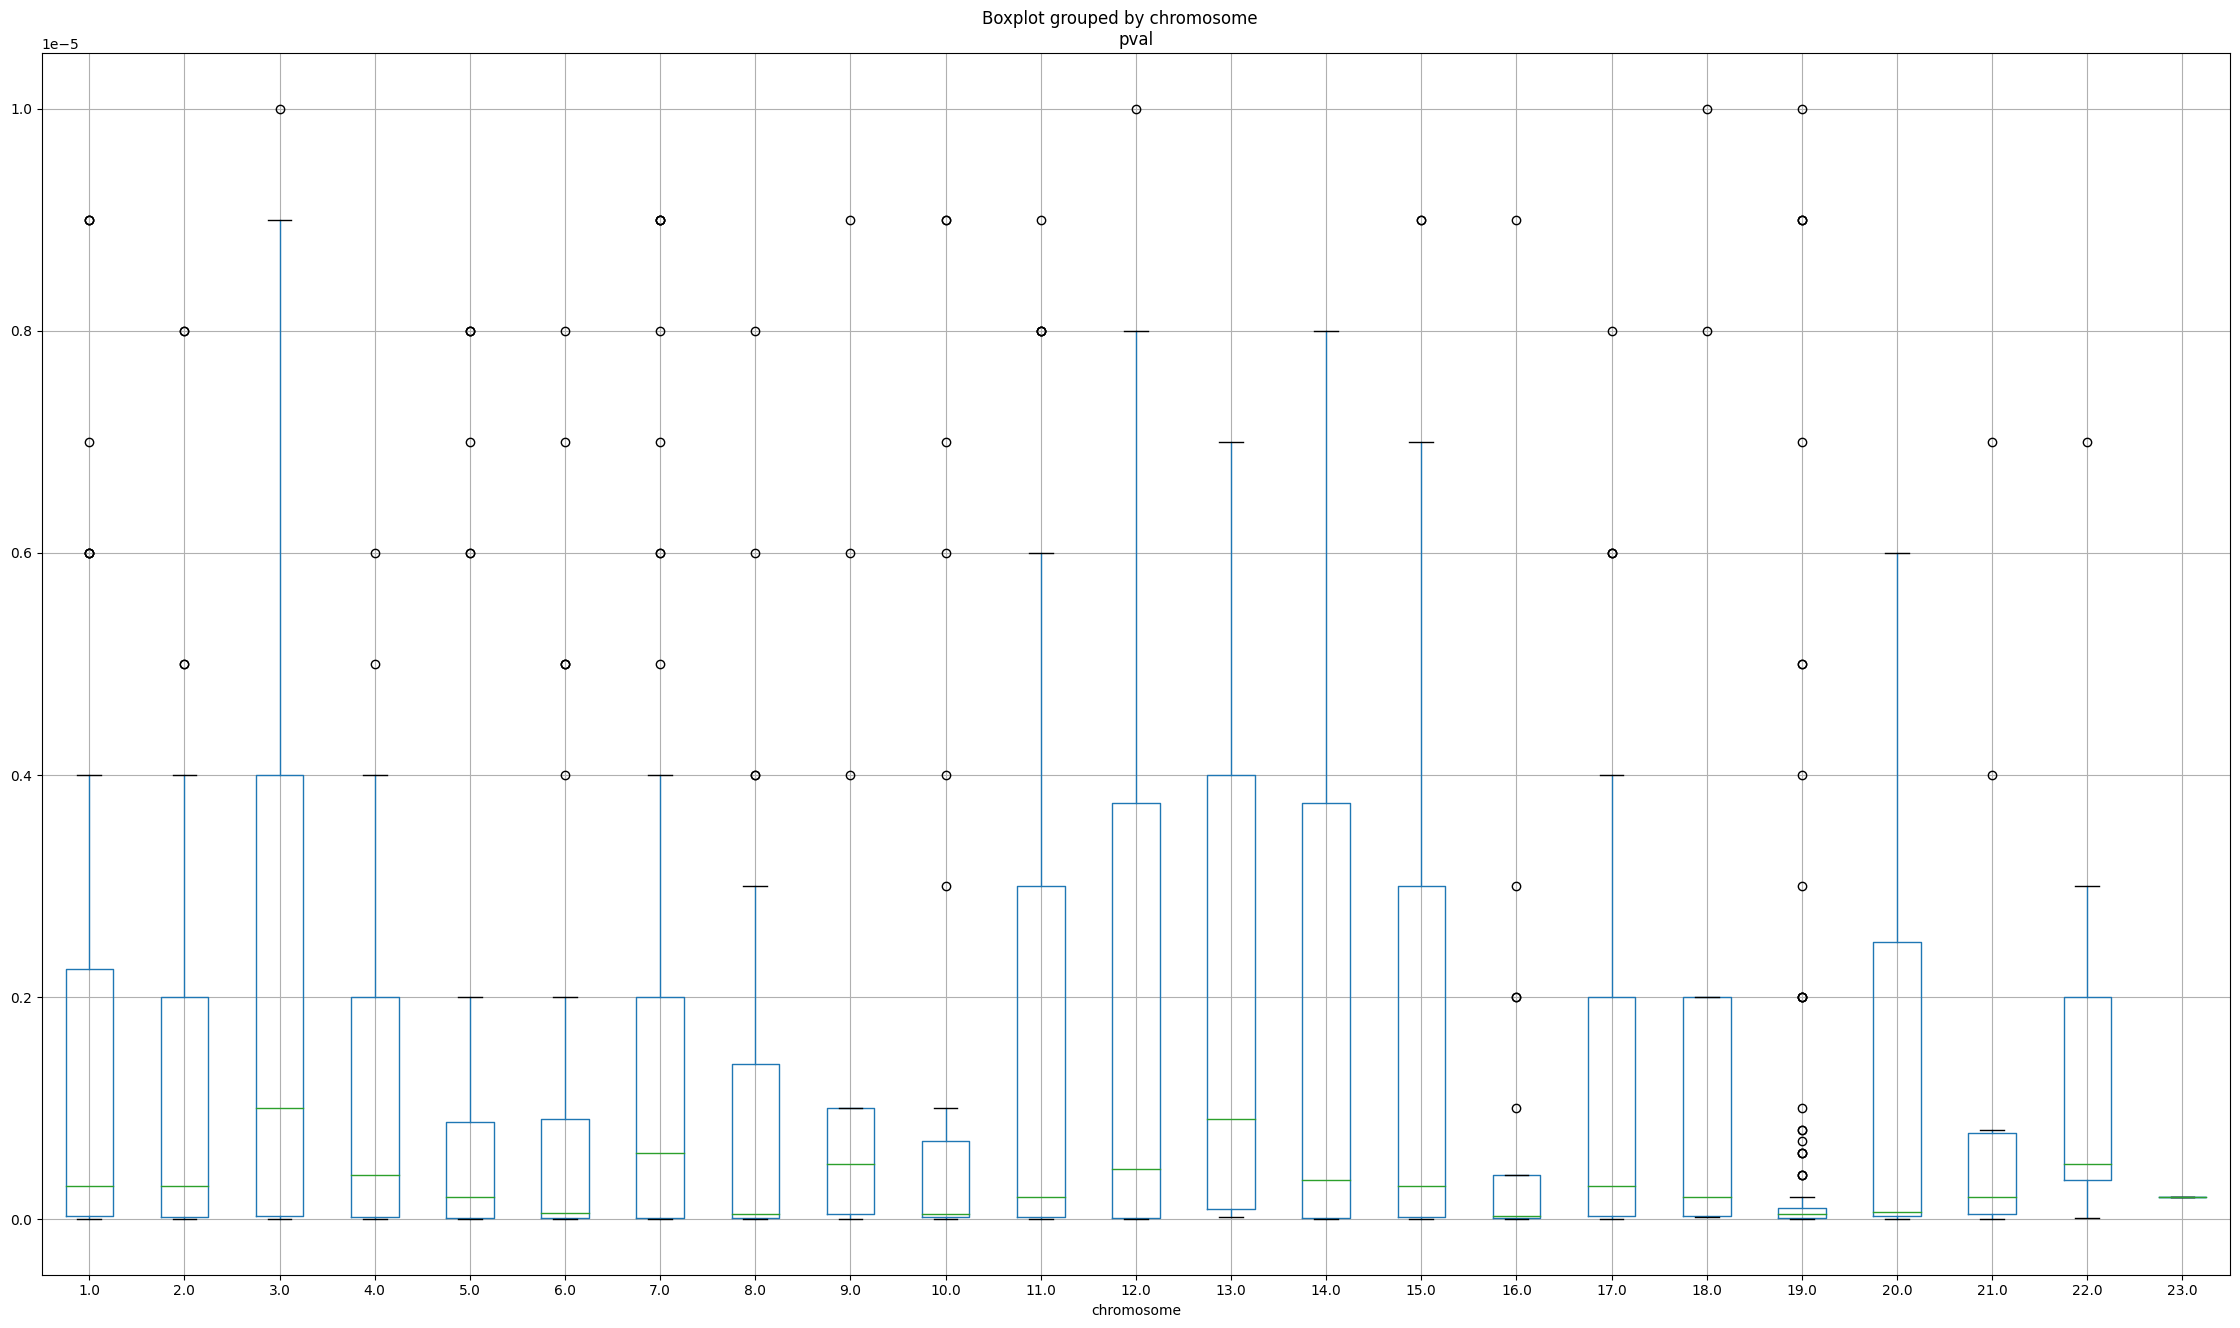

In [569]:
observation_size = data_pval.shape[0]
print(observation_size)

plt.rcParams["figure.figsize"] = [22.50, 13.50]
plt.rcParams["figure.autolayout"] = True
_ = data_pval.boxplot('pval', by='chromosome')

<AxesSubplot:>

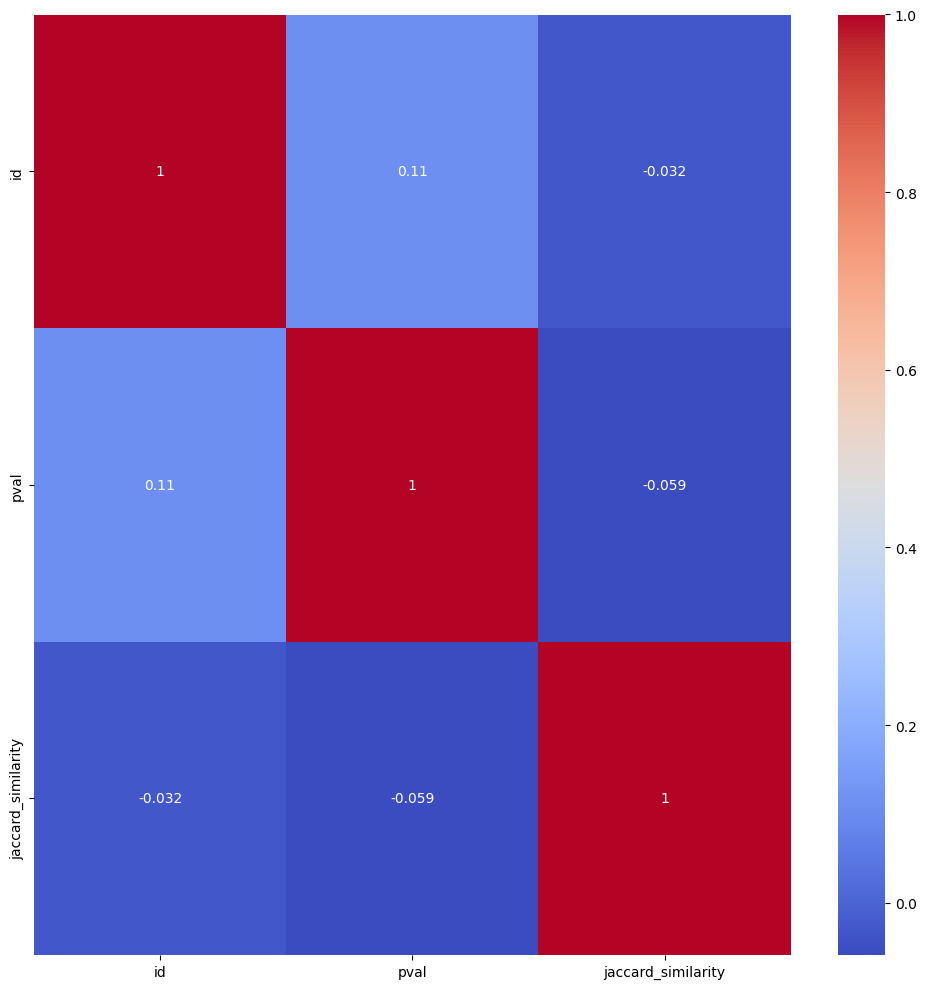

In [570]:
# Corelation ofotherfeatures with pval
# A value closer to 1 implies stronger positive correlation
# A value closer to -1 implies stronger negative correlation

corr = nodesSelectedCols.corr()
plt.figure(figsize=(10,10))
corr_heatmap = sns.heatmap(corr, annot = True, cmap='coolwarm')

corr_heatmap

In [571]:
# if (10**(-9) <= data_pval['pval']) & (data_pval['pval'] < 10**(-10)): c += 1

n1 = data_pval.loc[(data_pval['pval'] < 10**(-9)) & (data_pval['pval'] >= 10**(-10))]
n2 = data_pval.loc[(data_pval['pval'] < 10**(-8)) & (data_pval['pval'] >= 10**(-9))]
n3 = data_pval.loc[(data_pval['pval'] < 10**(-7)) & (data_pval['pval'] >= 10**(-8))]
n4 = data_pval.loc[(data_pval['pval'] < 10**(-6)) & (data_pval['pval'] >= 10**(-7))]
n5 = data_pval.loc[(data_pval['pval'] < 10**(-5)) & (data_pval['pval'] >= 10**(-6))]
n6 = data_pval.loc[(data_pval['pval'] < 10**(-4)) & (data_pval['pval'] >= 10**(-5))]
n7 = data_pval.loc[(data_pval['pval'] < 10**(-3)) & (data_pval['pval'] >= 10**(-4))]
n8 = data_pval.loc[(data_pval['pval'] < 10**(-2)) & (data_pval['pval'] >= 10**(-3))]
n9 = data_pval.loc[(data_pval['pval'] < 10**(-1)) & (data_pval['pval'] >= 10**(-2))]
n10 = data_pval.loc[(data_pval['pval'] >= 10**(-1))]

print('Total datapoints =', data_pval.shape[0])
print('Fromthe perspctiveof pval, among these data points')
print('Within range e-9 and e-10 :-', n1.shape[0])
print('Within range e-8 and e-9 :-', n2.shape[0])
print('Within range e-7 and e-8 :-', n3.shape[0])
print('Within range e-6 and e-7 :-', n4.shape[0])
print('Within range e-5 and e-6 :-', n5.shape[0])
print('Within range e-4 and e-5 :-', n6.shape[0])
print('Within range e-3 and e-4 :-', n7.shape[0])
print('Within range e-2 and e-3 :-', n8.shape[0])
print('Within range e-1 and e-2 :-', n9.shape[0])
print('All aboove e-1 :-', n9.shape[0])

print(59+105+206+146+246+4)

Total datapoints = 766
Fromthe perspctiveof pval, among these data points
Within range e-9 and e-10 :- 59
Within range e-8 and e-9 :- 105
Within range e-7 and e-8 :- 206
Within range e-6 and e-7 :- 146
Within range e-5 and e-6 :- 246
Within range e-4 and e-5 :- 4
Within range e-3 and e-4 :- 0
Within range e-2 and e-3 :- 0
Within range e-1 and e-2 :- 0
All aboove e-1 :- 0
766


In [555]:
data_pval_new = data_pval
data_pval_new['converted pval'] = 100
data_pval_new

/var/folders/48/43ljbwhj361953hbznd6h6qc0000gn/T/ipykernel_92080/3868967419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pval_new['converted pval'] = 100


,id,chromosome,jaccard_similarity,pval,converted pval
4,4,16.0,0.002947,4.000000e-08,100
7,7,15.0,0.012022,1.000000e-09,100
66,66,1.0,0.002709,9.000000e-06,100
71,71,7.0,0.002951,4.000000e-06,100
83,83,10.0,0.012946,5.000000e-09,100
...,...,...,...,...,...
7707,7707,7.0,0.000737,3.000000e-08,100
7711,7711,7.0,0.004177,2.000000e-09,100
7713,7713,18.0,0.002464,3.000000e-08,100
7714,7714,19.0,0.001723,5.000000e-08,100


In [577]:
data_pval_new.loc[(data_pval_new['pval'] < 10**(-8)) & (data_pval_new['pval'] >= 10**(-9)), 'converted pval'] = 90
data_pval_new.loc[(data_pval_new['pval'] < 10**(-7)) & (data_pval_new['pval'] >= 10**(-8)), 'converted pval'] = 80
data_pval_new.loc[(data_pval_new['pval'] < 10**(-6)) & (data_pval_new['pval'] >= 10**(-7)), 'converted pval'] = 70
data_pval_new.loc[(data_pval_new['pval'] < 10**(-5)) & (data_pval_new['pval'] >= 10**(-6)), 'converted pval'] = 60
data_pval_new.loc[(data_pval_new['pval'] < 10**(-4)) & (data_pval_new['pval'] >= 10**(-5)), 'converted pval'] = 50
data_pval_new.loc[(data_pval_new['pval'] < 10**(-3)) & (data_pval_new['pval'] >= 10**(-4)), 'converted pval'] = 40
data_pval_new.loc[(data_pval_new['pval'] < 10**(-2)) & (data_pval_new['pval'] >= 10**(-3)), 'converted pval'] = 30
data_pval_new = data_pval_new.drop(columns=['pval'])
data_pval_new

,id,chromosome,jaccard_similarity,converted pval
4,4,16.0,0.002947,80
7,7,15.0,0.012022,90
66,66,1.0,0.002709,60
71,71,7.0,0.002951,60
83,83,10.0,0.012946,90
...,...,...,...,...
7707,7707,7.0,0.000737,80
7711,7711,7.0,0.004177,90
7713,7713,18.0,0.002464,80
7714,7714,19.0,0.001723,80


In [593]:
chromosome_list = nodeList = data_pval_new["chromosome"].values.tolist()
print(len(set(chromosome_list)))

23


In [578]:
# sort by node_id
nodesSelectedCols = data_pval_new.sort_values(by=['id'])

nodeList = nodesSelectedCols["id"].values.tolist()
print('nodeList len', len(nodeList))

nodeList len 766


In [579]:
# filter edges that are not in selected nodes
edgesDfFiltered = edgesDf[edgesDf['source'].isin(nodeList)]
edgesDfFiltered = edgesDfFiltered[edgesDfFiltered['sink'].isin(nodeList)]
print('edgesDfFiltered shape', edgesDfFiltered.shape)

edgesDfFiltered shape (2473, 2)


In [580]:
# build adj matrix
numNodes = len(nodeList)
adj = np.zeros((numNodes, numNodes))

for index, row in edgesDfFiltered.iterrows():
    u = nodeList.index(row['source'])
    v = nodeList.index(row['sink'])
    adj[u][v] = 1
    adj[v][u] = 1

adj = sparse.csr_matrix(adj)
print('adj shape', adj.shape)

adj shape (766, 766)


In [581]:
# convert to pd df
adjDf = pd.DataFrame(adj.todense())
print('adj df shape', adjDf.shape)

adj df shape (766, 766)


In [582]:
# drop node_id column
nodesSelectedCols = nodesSelectedCols.drop('id', axis=1).reset_index(drop=True)
print(nodesSelectedCols)

     chromosome  jaccard_similarity  converted pval
0          16.0            0.002947              80
1          15.0            0.012022              90
2           1.0            0.002709              60
3           7.0            0.002951              60
4          10.0            0.012946              90
..          ...                 ...             ...
761         7.0            0.000737              80
762         7.0            0.004177              90
763        18.0            0.002464              80
764        19.0            0.001723              80
765         1.0            0.000493             100

[766 rows x 3 columns]


In [583]:
# conbine adj and node attributes
features = nodesSelectedCols.join(adjDf)
print('features.shape', features.shape)

features.shape (766, 769)


In [584]:
# one hot encode chromosome
oneHot = pd.get_dummies(features['chromosome'], prefix = 'chromosome')
featuresOneHot = features.join(oneHot)
featuresOneHot = featuresOneHot.drop('chromosome', axis = 1)

print('featuresOneHot shape', featuresOneHot.shape)

featuresOneHot shape (766, 791)


In [586]:
x = featuresOneHot.drop('converted pval', axis=1)
y = featuresOneHot['converted pval']
print(x.shape, y.shape)

(766, 790) (766,)


In [587]:
from sklearn.model_selection import train_test_split

x = x.values
y = y.values

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=104, test_size=0.25, shuffle=True)

# RandomForestRegressor

In [588]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
 
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(x_train, y_train)

y_pred = regressor.predict(x_test)
y_pred = pd.Series(y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
mae = mean_absolute_error(y_test, y_pred)
print('MSE:', mse, 'RMSE:', rmse, 'MAE:', mae)

MSE: 176.41593652068255 RMSE: 13.282166108006727 MAE: 10.995901101490274


In [589]:
actualVsPred = np.stack((y_test, y_pred), axis=1)
actualVsPred = pd.DataFrame(actualVsPred, columns = ['actual','predicted'])
actualVsPred

,actual,predicted
0,60.0,78.550000
1,80.0,77.973333
2,70.0,62.000000
3,80.0,79.702381
4,80.0,69.895238
...,...,...
187,70.0,85.676667
188,80.0,76.520451
189,90.0,87.305952
190,100.0,74.715000


# XGBRegressor

In [590]:
from xgboost.sklearn import XGBRegressor

regressor = XGBRegressor(n_estimators=100, random_state=0)
regressor.fit(x_train, y_train)

y_pred = regressor.predict(x_test)
y_pred = pd.Series(y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
mae = mean_absolute_error(y_test, y_pred)
print('MSE:', mse, 'RMSE:', rmse, 'MAE:', mae)

MSE: 192.25269824339694 RMSE: 13.865521924666123 MAE: 11.373734712600708


In [200]:
actualVsPred = np.stack((y_test, y_pred), axis=1)
actualVsPred = pd.DataFrame(actualVsPred, columns = ['actual','predicted'])
actualVsPred

,actual,predicted
0,5.000000e-08,0.000001
1,2.000000e-09,0.000001
2,3.000000e-07,0.000001
3,7.000000e-09,0.000001
4,5.000000e-06,0.000001
...,...,...
234,3.000000e-08,0.000001
235,1.000000e-06,0.000001
236,1.000000e-06,0.000001
237,4.000000e-07,0.000001
